In [1]:
!conda install gensim
!conda install fasttext

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



### Fasttext效果测试

In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2023-03-20 10:56:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz     22%[===>                ] 978.62M  2.72MB/s    in 6m 50s  

2023-03-20 11:03:33 (2.39 MB/s) - Read error at byte 1026161458/4503593528 (error:1408F119:SSL routines:ssl3_get_record:decryption failed or bad record mac). Retrying.

--2023-03-20 11:03:34--  (try: 2)  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 4503593528 (4.2G), 3477432070 (3.2G) remaining [applicati

In [5]:
!gunzip ./cc.en.300.bin.gz 

In [1]:
import gensim
import numpy as np
# Load the FastText pre-trained model
model = gensim.models.fasttext.load_facebook_model('cc.en.300.bin')

def get_fasttext_vector(line):
    vec = np.zeros(300) # Initialize an empty 300-dimensional vector
    for word in line.split():
        vec += model.wv[word]
    vec /= len(line.split()) # Take the average over all words in the line
    return vec

In [2]:
positive_text = """Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone"""
negative_text = """First, these should be called Mac - Coconut bars, as Coconut is the #2 ingredient and Mango is #3.  Second, lots of people don't like coconut.  I happen to be allergic to it.  Word to Amazon that if you want happy customers to make things like this more prominent.  Thanks."""

positive_example_in_fasttext = get_fasttext_vector(positive_text)
negative_example_in_fasttext = get_fasttext_vector(negative_text)

positive_review_in_fasttext = get_fasttext_vector("An Amazon review with a positive sentiment.")
negative_review_in_fasttext = get_fasttext_vector('An Amazon review with a negative sentiment.')

In [4]:
from openai.embeddings_utils import cosine_similarity

def get_fasttext_score(sample_embedding):
  return cosine_similarity(sample_embedding, positive_review_in_fasttext) - cosine_similarity(sample_embedding, negative_review_in_fasttext)

positive_score = get_fasttext_score(positive_example_in_fasttext)
negative_score = get_fasttext_score(negative_example_in_fasttext)

print("Fasttext好评例子的评分 : %f" % (positive_score))
print("Fasttext差评例子的评分 : %f" % (negative_score))

Fasttext好评例子的评分 : -0.000544
Fasttext差评例子的评分 : 0.000369


### T5效果测试

In [5]:
# install transformers if required
#!conda install -y transformers -c conda-forge
#!conda install -y pytorch torchvision -c pytorch
#!conda install -y sentencepiece

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch

# load the T5 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('t5-small', model_max_length=512)
model = AutoModel.from_pretrained('t5-small')

# set the model to evaluation mode
model.eval()

# encode the input sentence
def get_t5_vector(line):
    input_ids = tokenizer.encode(line, return_tensors='pt', max_length=512, truncation=True)
    # generate the vector representation
    with torch.no_grad():
        outputs = model.encoder(input_ids=input_ids)
        vector = outputs.last_hidden_state.mean(dim=1)
    return vector[0]

In [7]:
positive_review_in_t5 = get_t5_vector("An Amazon review with a positive sentiment.")
negative_review_in_t5 = get_t5_vector('An Amazon review with a negative sentiment.')

def test_t5():
  positive_example_in_t5 = get_t5_vector(positive_text)
  negative_example_in_t5 = get_t5_vector(negative_text)

  def get_t5_score(sample_embedding):
    return cosine_similarity(sample_embedding, positive_review_in_t5) - cosine_similarity(sample_embedding, negative_review_in_t5)

  positive_score = get_t5_score(positive_example_in_t5)
  negative_score = get_t5_score(negative_example_in_t5)

  print("T5好评例子的评分 : %f" % (positive_score))
  print("T5差评例子的评分 : %f" % (negative_score))

test_t5()

T5好评例子的评分 : -0.010294
T5差评例子的评分 : -0.008990


In [9]:
tokenizer = AutoTokenizer.from_pretrained('t5-base', model_max_length=512)
model = AutoModel.from_pretrained('t5-base')

# set the model to evaluation mode
model.eval()

# encode the input sentence
def get_t5_vector(line):
    input_ids = tokenizer.encode(line, return_tensors='pt', max_length=512, truncation=True)
    # generate the vector representation
    with torch.no_grad():
        outputs = model.encoder(input_ids=input_ids)
        vector = outputs.last_hidden_state.mean(dim=1)
    return vector[0]

positive_review_in_t5 = get_t5_vector("An Amazon review with a positive sentiment.")
negative_review_in_t5 = get_t5_vector('An Amazon review with a negative sentiment.')

test_t5()

T5好评例子的评分 : 0.010347
T5差评例子的评分 : -0.023935


In [10]:
import pandas as pd
from sklearn.metrics import classification_report

datafile_path = "data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)


df["t5_embedding"] = df.Text.apply(get_t5_vector)
# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

              precision    recall  f1-score   support

    negative       0.60      0.90      0.72       136
    positive       0.98      0.90      0.94       789

    accuracy                           0.90       925
   macro avg       0.79      0.90      0.83       925
weighted avg       0.93      0.90      0.91       925



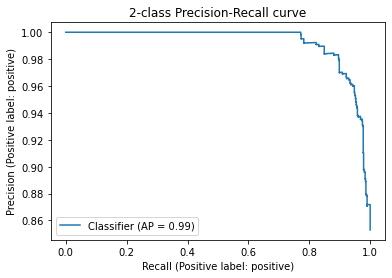

In [12]:
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach():
    def label_score(review_embedding):
        return cosine_similarity(review_embedding, positive_review_in_t5) - cosine_similarity(review_embedding, negative_review_in_t5)

    probas = df["t5_embedding"].apply(lambda x: label_score(x))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach()
